In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import IPython

---
## Question 1:

Read chapter 4 from Haykin’s book (2nd edition), starting from section 4.1 to 4.6(including 4.6). Summarize or sketch your insights in mind-map or an outline or a summary.

---
## Question 2:

For this task you have to program the back-propogation (BP) for multi layered perceptron (MLP). Design your implementation for general NN with arbitrary many hidden layers. The test case is as follows:  2-2-1 multi layered perceptron (MLP) with sigmoid activation function on XOR data.

In [233]:
class NeuralNetwork():
    """
    3 layer neural network with 1 input layer, 1 hidden layer, 
    1 output layer...
    2-2-1 Neural Network..
    """
    def __init__(self, num_hidden_neurons = 2, learning_rate = 1, epochs = 200000,
                 num_inputs = 2, zero_weight_init = False, epsilon= 1e-5):
        # Layer 0 --> input, Layer 1 --> hidden, Layer 2 --> output
        if zero_weight_init == False:
            np.random.seed(0)
            # weights randomly initialized...
            self.w_layer01 = np.random.rand(num_inputs + 1, num_hidden_neurons)
            self.w_layer12 = np.random.rand(num_hidden_neurons + 1, 1)
        else:
            # weights initialized to zero...
            self.w_layer01 = np.zeros((num_inputs + 1, num_hidden_neurons))
            self.w_layer12 = np.zeros((num_hidden_neurons + 1, 1))
            
        self.num_hidden_neurons = num_hidden_neurons
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epochs = epochs
        
    def non_linearity(self, value, derivative = False):
        if derivative == True: # return slope of sigmoid..
            return value * (1. - value)
        # included to avoid overflow in numpy exponent..
        value = np.array(value, dtype = np.float128)
        value = np.clip( value, -500, 500 )
        # return sigmoid activation value...
        return 1./(1. + np.exp(-value)) 
        
    def train(self, input_array, output_array):
        layer0 = np.insert(input_array, 0, 1, axis = 1)
        iteration, prev_delta = 0, np.ones(output_array.shape)
        conv_count = 0
        while(True):
            layer1_local_field = layer0.dot(self.w_layer01)
            layer1_output = self.non_linearity(layer1_local_field)
            layer1_output = np.insert(layer1_output, 0, 1, axis = 1)
            
            layer2_local_field = layer1_output.dot(self.w_layer12)
            layer2_output = self.non_linearity(layer2_local_field)
        
            layer2_error = -(output_array - layer2_output)
            layer2_delta = layer2_error * self.non_linearity(
                layer2_output, derivative = True)
            
            layer1_error = layer2_delta.dot(self.w_layer12.T)
            layer1_delta = layer1_error * self.non_linearity(
                layer1_output, derivative = True)
            layer1_delta = np.delete(layer1_delta, 0, 1)
            
            # update weights based on error and slope of sigmoid...
            self.w_layer12 -= self.learning_rate * (
                layer1_output.T.dot(layer2_delta))
            
            self.w_layer01 -= self.learning_rate * (
                layer0.T.dot(layer1_delta))
            
            #check_convergence = prev_delta - delta
            training_error = np.mean(np.abs(layer2_error))
            
            if np.all(layer2_delta < self.epsilon):
                conv_count += 1
            else:
                conv_count = 0
            
            if iteration % 100000 == 0:
                print 'Epoch: ', iteration, '......', 'Training Error: ', (
                    training_error)
            if iteration > self.epochs or conv_count >= 5: # low delta for more than 5 epochs.. 
                break
            
            prev_delta = layer2_delta.copy()
            iteration += 1
                
        # training error at the end of epochs is returned...
        print '-----------------------------------------------------------'
        if iteration > self.epochs: 
            print 'Max epochs reached...'
        else:
            print 'Epoch: ', iteration, '......', 'Training Error: ', (
                    training_error)
            print 'Error has converged...'
        print '-----------------------------------------------------------'
        return [training_error, iteration]
                
    def predict(self, input_array, labels= []):
        layer0 = np.insert(input_array, 0, 1, axis = 1)
        layer1_local_field = layer0.dot(self.w_layer01)
        layer1_output = self.non_linearity(layer1_local_field)
        layer1_output = np.insert(layer1_output, 0, 1, axis = 1)
        
        layer2_local_field = layer1_output.dot(self.w_layer12)
        layer2_output = self.non_linearity(layer2_local_field)
        
        if labels == []:
            return layer2_output
        else:
            layer2_error = layer2_output - labels
            # average generalization error is returned..
            return np.mean(np.abs(layer2_error))

In [248]:
# XOR..
input_data = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
labels = np.array([0., 1., 1., 0.]).reshape(-1, 1)

print input_data.shape
print labels.shape

(4, 2)
(4, 1)


## 2) a) Experiments with initial weights

### i) Train the network with zero initial weights i.e. $w_{ij} = 0$.

In [235]:
network = NeuralNetwork(zero_weight_init= True)
error = network.train(input_data, labels)[0]

Epoch:  0 ...... Training Error:  0.5
Epoch:  100000 ...... Training Error:  0.5
Epoch:  200000 ...... Training Error:  0.5
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------


## ii) Train with random initial weights:

In [236]:
network = NeuralNetwork(zero_weight_init= False)
error = network.train(input_data, labels)[0]

Epoch:  0 ...... Training Error:  0.497746545722
Epoch:  100000 ...... Training Error:  0.00347258627308
-----------------------------------------------------------
Epoch:  152999 ...... Training Error:  0.00279332752519
Error has converged...
-----------------------------------------------------------


In [247]:
for data in input_data:
    print data, '--->', network.predict(data.reshape(1, -1))[0][0]

[ 0.  0.] ---> 0.00316723955281
[ 0.  1.] ---> 0.997345094618
[ 1.  0.] ---> 0.997345338366
[ 1.  1.] ---> 0.00269646623792


## Comparision and Comments on convergence:

Weights initialized to zero:

    

Weights initialized to random values:

    
    
---

## b. Experiment with different learning rates e.g. 0.1, 0.3, 0.5, 0.9:

In [249]:
learning_rates = [0.1, 0.3, 0.5, 0.9]
converged_error = []
epochs = []
for rate in learning_rates:
    network = NeuralNetwork(learning_rate=rate)
    result = network.train(input_data, labels)
    converged_error.append(result[0])
    epochs.append(result[1])

print 'Errors after convergence: '
print '[learning_rate, converged error]'
learn_error = np.array(zip(learning_rates, converged_error))
print learn_error
print '-----------------------------------------------------------'
print 'Epochs taken for convergence: '
print '[learning_rate, epochs]'
learn_epoch = np.array(zip(learning_rates, epochs))
print learn_epoch

Epoch:  0 ...... Training Error:  0.497746545722
Epoch:  100000 ...... Training Error:  0.011701118089
Epoch:  200000 ...... Training Error:  0.00803360937907
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.497746545722
Epoch:  100000 ...... Training Error:  0.00648235146936
Epoch:  200000 ...... Training Error:  0.0045175939045
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.497746545722
Epoch:  100000 ...... Training Error:  0.00496501782795
Epoch:  200000 ...... Training Error:  0.00347260571629
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.497746545722
Epoch:  100000 ...... Training Error:  0.0036

## Compare the convergence and plot some resulting surfaces:

## Plot:

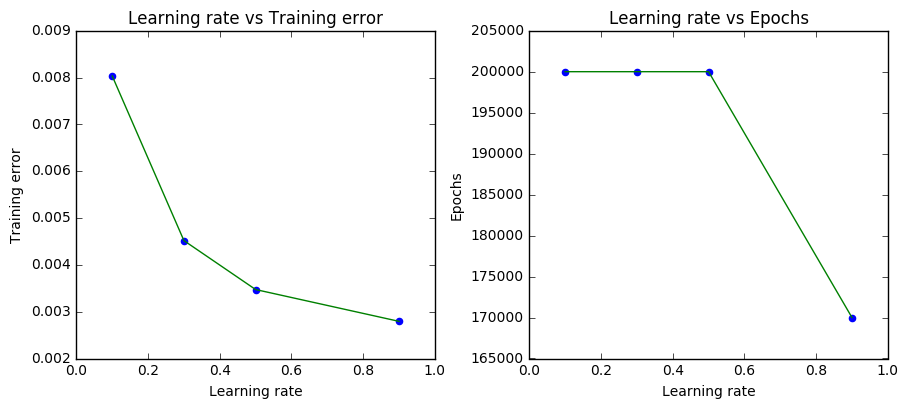

In [250]:
figure = plt.figure(1)
figure.set_figheight(5)
figure.set_figwidth(10)

figure.add_subplot(1, 2, 1)
plt.plot(learn_error[:,0], learn_error[:,1], color = 'g')
plt.xlabel('Learning rate')
plt.ylabel('Training error')
plt.title('Learning rate vs Training error')
plt.scatter(learn_error[:,0], learn_error[:,1], color = 'b')

figure.add_subplot(1, 2, 2)
plt.tight_layout(pad= 4.00)
plt.plot(learn_epoch[:,0], learn_epoch[:,1], color = 'g')
plt.xlabel('Learning rate')
plt.ylabel('Epochs')
plt.title('Learning rate vs Epochs')
plt.scatter(learn_epoch[:,0], learn_epoch[:,1], color = 'b')

plt.show()

## Comparision of convergence:

---

## Question 3:

Investigate the use of back-propagation learning using a sigmoidal nonlinearity to achieve one-to-one mappings, as described here:

For each mapping, do the following:

1. Set up two sets of data, one for network training, and the other for testing.

2. Use the training data set to compute the synaptic weights of the network, assumed to have a single hidden layer.

3. Evaluate the computation accuracy of the network by using the test data. Use a single hidden layer but with a variable number of hidden neurons. Investigate how the network performance is affected by varying the size of the hidden layer.

In [251]:
## Required functions....

def plot_results(hidden_neurons, train_error, test_error, 
                 plot_title, x_axis_lim = (None, None)):
    print 'Training error after convergence: '
    print '[Hidden neurons, converged training error]'
    print np.array(zip(hidden_neurons, train_error))
    print '--------------------------------------------------------------------'
    print 'Test error: '
    print '[Hidden neurons, test error]'
    print np.array(zip(hidden_neurons, test_error))

    plt.plot(hidden_neurons, train_error, color = 'r', label= "Training error")
    plt.plot(hidden_neurons, test_error, color = 'g', label= "Test error")
    plt.scatter(hidden_neurons, train_error, color = 'c', label= "Training error")
    plt.scatter(hidden_neurons, test_error, color = 'm', label= "Test error")
    plt.xlabel('Number of Hidden Neurons')
    plt.ylabel('Error')
    plt.title(plot_title)
    plt.xlim(x_axis_lim[0], x_axis_lim[1])
    plt.legend()
    plt.show()

def obtain_performance(x, y, hidden_neurons):
    data = np.hstack((x, y))
    np.random.seed(0)
    np.random.shuffle(data)
    train_data, test_data = np.vsplit(data, [data.shape[0]*8/10])

    train_error = []
    test_error = []

    for number in hidden_neurons:
        network = NeuralNetwork(num_inputs= 1,
                            num_hidden_neurons= number)
        train_error.append(network.train(train_data[:,:-1],
                                     train_data[:,-1:])[0])
        test_error.append(network.predict(test_data[:,:-1],
                                     labels= test_data[:,-1:]))
        
    return train_error, test_error

In [252]:
hidden_neurons = [1, 2, 3, 4, 5]

## 1) Reciprocal 
$$F(x) = \frac{1}{x}; 1<= x <=100$$

Epoch:  0 ...... Training Error:  0.7069425571
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.0581322330746
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.764822793151
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.0581322376342
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.878796666167
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.0581314333135
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.904857956396
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.0580776179184
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  

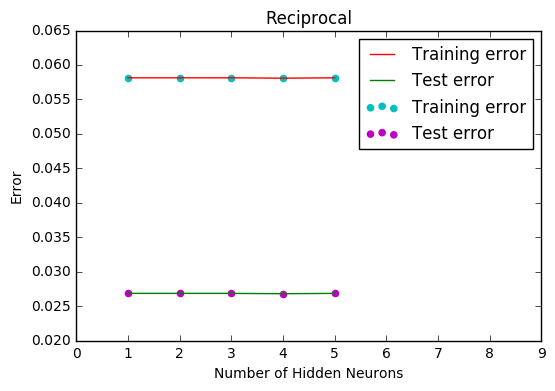

In [253]:
reciprocal_x = np.arange(1, 101, dtype= np.float32).reshape(-1, 1)
reciprocal_y = 1/reciprocal_x
train_error_r, test_error_r = obtain_performance(
    reciprocal_x, reciprocal_y, hidden_neurons)
plot_results(hidden_neurons, train_error_r, test_error_r,
             'Reciprocal',  x_axis_lim= (0, 9))

## 2) Log_10
$$F(x) = log_{10}x; 1<= x <=10$$

Epoch:  0 ...... Training Error:  0.200062313963
Epoch:  100000 ...... Training Error:  0.0474856172589
Epoch:  200000 ...... Training Error:  0.0474856172589
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.196812471553
Epoch:  100000 ...... Training Error:  0.00543480431728
Epoch:  200000 ...... Training Error:  0.00500427759236
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.22629788463
Epoch:  100000 ...... Training Error:  0.00673827028993
Epoch:  200000 ...... Training Error:  0.00911869972148
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.245094380387
Epoch:  100000 ...... Training Error:  0.0052

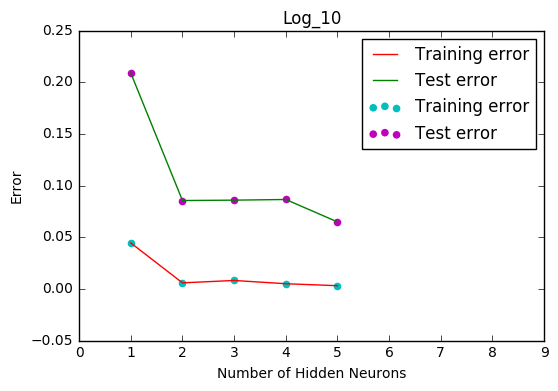

In [254]:
log_x = np.arange(1, 11, dtype= np.float32).reshape(-1, 1)
log_y = np.log10(log_x)
train_error_l, test_error_l = obtain_performance(
    log_x, log_y, hidden_neurons)
plot_results(hidden_neurons, train_error_l, test_error_l,
             'Log_10', x_axis_lim= (0, 9))

## 3) Exponential 
$$F(x) = exp(-x); 1<= x <=10$$

Epoch:  0 ...... Training Error:  0.729610561643
Epoch:  100000 ...... Training Error:  0.00157533000096
Epoch:  200000 ...... Training Error:  0.00135529427574
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.785317682649
-----------------------------------------------------------
Epoch:  9428 ...... Training Error:  0.00164752459007
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.901437580515
Epoch:  100000 ...... Training Error:  0.000718026938794
Epoch:  200000 ...... Training Error:  0.000516654006306
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.931818466253
-----------------------------------------------------------
Epoch:  11880 ...... Training Error: 

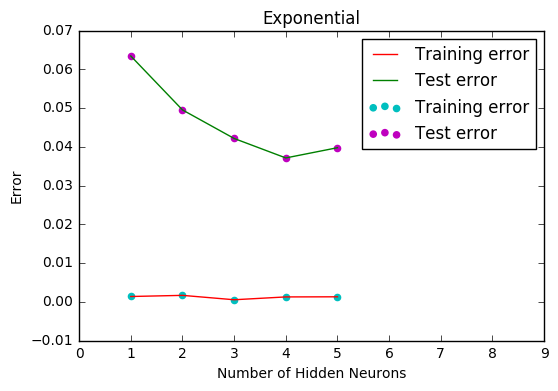

In [255]:
exp_x = np.arange(1, 11, dtype= np.float32).reshape(-1, 1)
exp_y = np.exp(-exp_x)
train_error_e, test_error_e = obtain_performance(
    exp_x, exp_y, hidden_neurons)
plot_results(hidden_neurons, train_error_e, test_error_e, 
             'Exponential',  x_axis_lim= (0, 9))

## 4) Sinusoid 
$$F(x) = sin(x); 0<= x <=\frac{\pi}{2}$$

Epoch:  0 ...... Training Error:  0.249409410518
Epoch:  100000 ...... Training Error:  0.0671843050992
Epoch:  200000 ...... Training Error:  0.0671843050992
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.251353417207
Epoch:  100000 ...... Training Error:  0.0428746642237
Epoch:  200000 ...... Training Error:  0.0428746642237
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.28853769008
Epoch:  100000 ...... Training Error:  0.0398713907209
Epoch:  200000 ...... Training Error:  0.0398783595539
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.315798107827
Epoch:  100000 ...... Training Error:  0.00344510

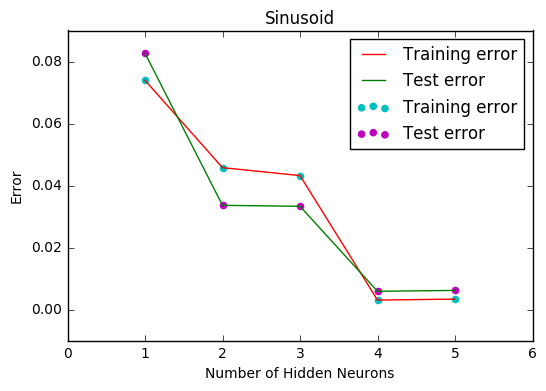

In [256]:
sin_x = np.linspace(0, np.pi/2, dtype= np.float32).reshape(-1, 1)
sin_y = np.sin(sin_x)
train_error_s, test_error_s = obtain_performance(
    sin_x, sin_y, hidden_neurons)
plot_results(hidden_neurons, train_error_s, test_error_s, 'Sinusoid')

---